<center>
<h1> Credit Risk Analytics <h1>
</center>

###### Definition of Target and Outcome Window:
One of the leading banks would like to predict bad customer while customer applying for loan. This model also called as PD Models (Probability of Default)
    
###### Data Pre-Processing - 
    - Missing Values Treatment - Numerical (Mean/Median imputation) and Categorical (Separate Missing Category or Merging)
    - Univariate Analysis - Outlier and Frequency Analysis
###### Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)
    - Bivariate Analysis - Visualization
    - Variable Transformation - P-Value based selection
    - Variable Transformation - Bucketing / Binning for numerical variables and Dummy for Categorical Variables
    - Variable Reduction - IV / Somers'D
    - Variable Reduction - Multicollinearity
###### Model Build and Model Diagnostics
    - Train and Test split
    - Significance of each Variable
    - ROC / Concordance analysis - Rank Ordering
    - Classification Table Analysis - Accuracy

### Import packages:

In [33]:
 import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy.stats as stats  # hypothesis testing

import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score

# roc_auc_score is concordance

### Data availability:

In [34]:
bankloans = pd.read_csv("E:\PYTHON_ANALYTICSLAB\logistic reression case study\Bankloans - 1684222194668.csv")
bankloans

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0
...,...,...,...,...,...,...,...,...,...
845,34,1,12,15,32,2.7,0.239328,0.624672,NaN
846,32,2,12,11,116,5.7,4.026708,2.585292,NaN
847,48,1,13,11,38,10.8,0.722304,3.381696,NaN
848,35,2,1,11,24,7.8,0.417456,1.454544,NaN


### Data Auditing ( EDA ):

In [35]:
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


### Get UDF for the detection of missing values & outliers:

In [36]:
def continuous_var_summary( x ):
    
    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total
    
    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr
    
    
    return pd.Series( [ x.dtype, x.nunique(), n_total, x.count(), n_miss, perc_miss,
                       x.sum(), x.mean(), x.std(), x.var(), 
                       lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max() ], 
                     
                    index = ['dtype', 'cardinality', 'n_tot', 'n', 'nmiss', 'perc_miss',
                             'sum', 'mean', 'std', 'var',
                        'lc_iqr', 'uc_iqr',
                        'min', 'p1', 'p5', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99', 'max']) 

In [37]:
# Missing value imputation for categorical and continuous variables

def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    return x

### Deciding the y variable:
        
        default is y variables as we have to do predictions on this variable

In [38]:
bankloans.nunique()

age          37
ed            5
employ       33
address      32
income      129
debtinc     245
creddebt    842
othdebt     848
default       2
dtype: int64

#### Count of Values in the default variable:

In [39]:
bankloans.default.value_counts()

0.0    517
1.0    183
Name: default, dtype: int64

#### %age of values in each category of default:

In [40]:
bankloans.default.value_counts() / bankloans.default.count()

0.0    0.738571
1.0    0.261429
Name: default, dtype: float64

### DATA BALANCING:
        
        
        - Each category must have the data atleast 20%.
        
        
                    0 : 85% 
                    1 : 15%
                
                Data is imbalanced.
                
        - To balance the data, we can perform:
                    
                    a. OVERBALANCING    b. UNDERBALANCING   c. OVER-UNDER BALANCING
                    
                         
                         OVERBALANCING        UNDERBALANCING          OVER-UNDER BALANCING
                    
          0 : 85%         0: 85%                 0: 15%                0: 45%
          1 : 15%         1: 85%                 1: 15%                1: 55%

### Separate the existing & new customers:

In [41]:
bankloans_existing = bankloans[bankloans.default.notna()]
bankloans_new = bankloans[ bankloans.default.isna() ]

In [42]:
bankloans_existing.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [43]:
bankloans_new.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN


### Summary of existing customers:

##### Detection of outliers & missing values:

In [44]:
bankloans_existing.apply(continuous_var_summary)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
dtype,int64,int64,int64,int64,int64,float64,float64,float64,float64
cardinality,37,5,32,31,114,231,695,699,2
n_tot,700,700,700,700,700,700,700,700,700
n,700,700,700,700,700,700,700,700,700
nmiss,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,24402,1206,5872,5795,31921,7182.4,1087.486972,2140.746028,183.0
mean,34.86,1.722857,8.388571,8.278571,45.601429,10.260571,1.553553,3.058209,0.261429
std,7.997342,0.928206,6.658039,6.824877,36.814226,6.827234,2.117197,3.287555,0.439727
var,63.957482,0.861566,44.329483,46.578939,1355.287265,46.611118,4.482523,10.808015,0.19336


### Treatment of outliers & missing values:

In [45]:
##### Treatment of outliers:
bankloans_existing = bankloans_existing.apply(lambda x : x.clip(lower = x.quantile(0.01), 
                                                                upper = x.quantile(0.99) ) )

In [46]:
bankloans_existing.apply(continuous_var_summary)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
dtype,float64,int64,float64,float64,float64,float64,float64,float64,float64
cardinality,34,4,29,28,107,221,683,687,2
n_tot,700,700,700,700,700,700,700,700,700
n,700,700,700,700,700,700,700,700,700
nmiss,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,24393.07,1201,5851.07,5771.07,31394.1,7155.507,1049.190134,2119.103279,183.0
mean,34.847243,1.715714,8.358671,8.244386,44.848714,10.222153,1.498843,3.02729,0.261429
std,7.954735,0.906523,6.566008,6.721915,31.942133,6.68216,1.788451,3.115401,0.439727
var,63.277806,0.821784,43.112459,45.18414,1020.29987,44.651264,3.198555,9.705723,0.19336


In [47]:
#### Treatment of missing values:

# bankloans_existing = bankloans_existing.apply(lambda x: missing_imputation(x))

### Co-relations of variables:

In [48]:
banks_relations = bankloans_existing.corr()
banks_relations.to_csv('E:\PYTHON_ANALYTICSLAB\logistic reression case study\corelations.csv')

In [49]:
banks_relations

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
age,1.000000,0.016576,0.537417,0.596973,0.521450,0.016926,0.308318,0.348911,-0.138654
ed,0.016576,1.000000,-0.158071,0.055560,0.225395,0.009992,0.103012,0.156523,0.118521
employ,0.537417,-0.158071,1.000000,0.324859,0.665369,-0.035332,0.405959,0.419337,-0.287197
address,0.596973,0.055560,0.324859,1.000000,0.345067,0.014967,0.215397,0.234896,-0.165389
income,0.521450,0.225395,0.665369,0.345067,1.000000,-0.022541,0.553114,0.626787,-0.099553
debtinc,0.016926,0.009992,-0.035332,0.014967,-0.022541,1.000000,0.534602,0.603630,0.388556
creddebt,0.308318,0.103012,0.405959,0.215397,0.553114,0.534602,1.000000,0.639984,0.238179
othdebt,0.348911,0.156523,0.419337,0.234896,0.626787,0.603630,0.639984,1.000000,0.138962
default,-0.138654,0.118521,-0.287197,-0.165389,-0.099553,0.388556,0.238179,0.138962,1.000000


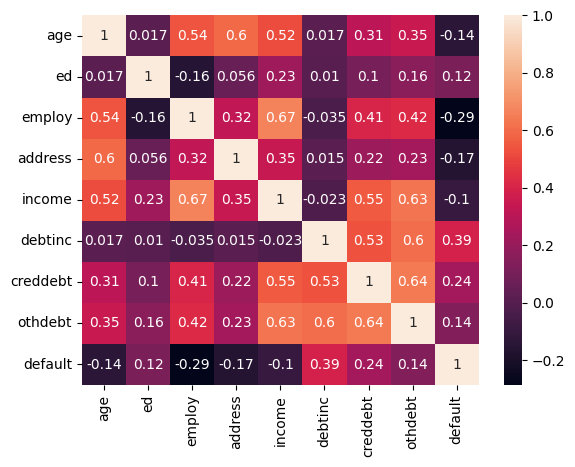

<Figure size 1200x800 with 0 Axes>

In [50]:
sns.heatmap(banks_relations, annot= True)
plt.figure(figsize = (12, 8))
plt.show()

## BUILDING MODEL :

##### i. Train-test split:

In [51]:
train, test = train_test_split(bankloans_existing, train_size= 0.7, test_size = 0.3, random_state = 12)

In [52]:
train.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
164,35.0,2,1.0,8.00,24.0,12.5,0.591000,2.409000,1.0
641,53.0,2,16.0,26.01,44.0,5.6,1.333024,1.130976,0.0
6,39.0,1,20.0,9.00,67.0,30.6,3.833874,16.668126,0.0
529,22.0,1,4.0,3.00,19.0,23.1,1.887270,2.501730,1.0
210,40.0,3,16.0,6.00,116.0,12.1,1.614140,12.421860,0.0


In [53]:
test.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
150,45.00,2,15.0,14.00,51.0,18.1,1.550808,7.680192,0.0
79,36.00,1,15.0,10.00,39.0,3.2,0.686400,0.561600,0.0
469,21.00,2,2.0,0.00,20.0,4.5,0.290700,0.609300,1.0
569,53.01,1,18.0,26.01,114.0,8.5,3.294600,6.395400,0.0
138,29.00,1,8.0,10.00,24.0,6.7,0.469536,1.138464,0.0


##### ii. Define & fit the model:

In [54]:
model_param = train.columns.difference(['default'])
model_param

Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt'],
      dtype='object')

In [55]:
# model formula : y ~ x1 + x2 + ......

formula0 = 'default ~ ' + ' + '.join(model_param)
formula0

'default ~ address + age + creddebt + debtinc + ed + employ + income + othdebt'

In [56]:
logm0 = smf.logit(formula0, data= train).fit()
logm0

Optimization terminated successfully.
         Current function value: 0.373385
         Iterations 8


##### iii. Model summary:

In [57]:
print(logm0.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.343     
Dependent Variable: default          AIC:              383.1705  
Date:               2023-05-23 20:08 BIC:              420.9018  
No. Observations:   489              Log-Likelihood:   -182.59   
Df Model:           8                LL-Null:          -277.96   
Df Residuals:       480              LLR p-value:      5.6533e-37
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.8060    0.7903  -2.2851  0.0223  -3.3551  -0.2570
address       -0.1234    0.0293  -4.2128  0.0000  -0.1808  -0.0660
age            0.0418    0.0214   1.9507  0.0511  -0.0002   0.0838
creddebt       0.6893    0.151

#### Data Exoloratory Analysis:

* Variable Reduction using "Somer's D values".
* Bi-variate analysis technique to check the predictive power of each independent against dependent
* **Cutoff is 0.2** or 20% below which the variable is *insignificant*

### Variable Reductions:
            
                          Linear Regression              Logistic Regression
   
   1. Feature Selection       f_regression()            somars'd values
                             fscore, p value            loop---> pred_prob, concordance, somars'd
                            
                            cut off depends on         cut off depends on somars'd
                            p value, i.e < 0.1             i.e.  > 0.2
                            
   2. Multi-colinearity       vif()                            vif()
   

#### i. Feature importance : get the Somer's D values for all the X variables. 

In [58]:
# empty dataframe to store the x variables & their corresponding concordance & somars'd score
somarsd_df = pd.DataFrame()

# iterate over all the x variables:
for i in bankloans_existing.columns.difference(['default']):
    
    # i. define & fit the model using one x and y variable:
    log_model = smf.logit('default ~ ' + i, data = bankloans_existing).fit()
    
    # ii. predict the y probabilities of each x variable:
    y_pred_prob = log_model.predict(bankloans_existing)
    
    # iii. find the concordance using roc_auc score():
    concor = roc_auc_score(bankloans_existing.default, y_pred_prob)
    
    # iv. find somars'd value using 2*concor -1:
    somarsd = 2*concor - 1
    
    # save the results in a temp data frame:
    temp_data = pd.DataFrame([i, concor, somarsd]).T
    
    # appending the data from temp to actual df:
    somarsd_df = pd.concat([somarsd_df, temp_data] , axis = 0)
    

somarsd_df.columns = ['Features', 'Concordance', 'Somarsd_Score']
somarsd_df = somarsd_df.reset_index(drop = True)
somarsd_df    
    

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


,Features,Concordance,Somarsd_Score
0,address,0.611192,0.222384
1,age,0.603165,0.206329
2,creddebt,0.636189,0.272378
3,debtinc,0.735253,0.470506
4,ed,0.574151,0.148302
5,employ,0.704569,0.409138
6,income,0.600136,0.200273
7,othdebt,0.586903,0.173806


In [59]:
features = list(somarsd_df.loc[somarsd_df.Somarsd_Score >= 0.2, 'Features'])
features

# these are significant X variables.

['address', 'age', 'creddebt', 'debtinc', 'employ', 'income']

#### ii. Multi-Colinearity :
            
        using VIF()

In [60]:
# run the dmatrices
equation = 'default ~ ' + ' + '.join( features)

a, b = dmatrices( equation, data = bankloans_existing, return_type = 'dataframe')

# get the VIF
vif = pd.DataFrame()

vif["Features"] = b.columns
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]

vif


,Features,VIF Factor
0,Intercept,28.286222
1,address,1.559236
2,age,2.036933
3,creddebt,2.564921
4,debtinc,1.778339
5,employ,1.997947
6,income,2.601717


### MODEL 1: After performing variable reductions:

In [61]:
#### i. Define & fit the model:

# Define model equation: y ~ x1 + x2 + ....
formula1 = 'default ~ ' + ' + '.join(features)

m1 = smf.logit(formula1, train).fit()

Optimization terminated successfully.
         Current function value: 0.374719
         Iterations 7


In [62]:
print(m1.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.341     
Dependent Variable: default          AIC:              380.4750  
Date:               2023-05-23 20:11 BIC:              409.8215  
No. Observations:   489              Log-Likelihood:   -183.24   
Df Model:           6                LL-Null:          -277.96   
Df Residuals:       482              LLR p-value:      3.3321e-38
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -2.1822    0.6523  -3.3454  0.0008  -3.4608  -0.9037
address       -0.1218    0.0292  -4.1727  0.0000  -0.1790  -0.0646
age            0.0395    0.0213   1.8526  0.0639  -0.0023   0.0814
creddebt       0.6244    0.134

### MODEL 2: Perform variabe reductions manually:

In [63]:
features =  ['address', 'creddebt', 'debtinc', 'employ']
features

['address', 'creddebt', 'debtinc', 'employ']

In [64]:
#### i. Define & fit the model:

# Define model equation: y ~ x1 + x2 + ....
formula1 = 'default ~ ' + ' + '.join(features)

m2 = smf.logit(formula1, train).fit()

Optimization terminated successfully.
         Current function value: 0.378780
         Iterations 7


In [65]:
#### ii. Model Summary:

print(m2.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.334     
Dependent Variable: default          AIC:              380.4473  
Date:               2023-05-23 20:14 BIC:              401.4091  
No. Observations:   489              Log-Likelihood:   -185.22   
Df Model:           4                LL-Null:          -277.96   
Df Residuals:       484              LLR p-value:      4.9676e-39
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.0435    0.3057  -3.4134  0.0006  -1.6426  -0.4443
address       -0.0918    0.0246  -3.7368  0.0002  -0.1399  -0.0436
creddebt       0.6536    0.1072   6.0973  0.0000   0.4435   0.8637
debtinc        0.1026    0.022

* **The above model, m2 is the final model after selecting the important features.**

### MODEL PREDICTIONS: 
            
                Predict the y values on both train & test data using .predict()

In [66]:
# predict the values on training and testing

train_predict = m2.predict(train)
test_predict = m2.predict(test)

In [67]:
train_predict.head()

164    0.408689
641    0.002143
6      0.194199
529    0.776317
210    0.030583
dtype: float64

In [69]:
test_predict.head()

150    0.033675
79     0.006165
469    0.286653
569    0.006159
138    0.045375
dtype: float64

### MODEL SCORING :
            
            To check the model accuracies.
    

In [70]:
##### Method 1: using AUC :

train_auc = roc_auc_score( train.default, train_predict )
test_auc = roc_auc_score( test.default, test_predict )

print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)

The AUC for the model built on the Train Data is :  0.8664835164835164
The AUC for the model built on the Test Data is :  0.8306488203266787


#### Combine the actual Y values with predicted probabilities:

In [71]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(train_predict)

# making a DataFrame with actual and prob columns
train_pf = pd.concat([ train.default, train_predicted_prob ], axis = 1).reset_index( drop = True )
train_pf.columns = ['actual', 'prob']
train_pf

,actual,prob
0,1.0,0.408689
1,0.0,0.002143
2,0.0,0.194199
3,1.0,0.776317
4,0.0,0.030583
...,...,...
484,0.0,0.077520
485,0.0,0.411375
486,0.0,0.088375
487,0.0,0.415057


In [72]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(test_predict)

# making a DataFrame with actual and prob columns
test_pf = pd.concat([ test.default, test_predicted_prob ], axis = 1).reset_index( drop = True )
test_pf.columns = ['actual', 'prob']
test_pf

,actual,prob
0,0.0,0.033675
1,0.0,0.006165
2,1.0,0.286653
3,0.0,0.006159
4,0.0,0.045375
...,...,...
205,1.0,0.436192
206,0.0,0.013908
207,0.0,0.310352
208,0.0,0.007727


### Get the best cutoff: 

        1. Senstivity + Specificity : MAXIMUM (SPEC + SENS) To get the best cutoff
        2. Accuracy
        3. TPR - True Positive Rate (Senstivity)
        
        
***We can choose based on the type of business problem.***

In [74]:
# we dont know the best cutoff; thus will iterate for each probability value between 0.0 and 1.0

# declare an empty dataframe 
df_best_cutoff = pd.DataFrame()

# iterate for different probabilities
for i in np.arange(0, 1.01, 0.01):
    
    # use one proba as cutoff and do the predictions
    y_predicted = pd.Series( np.where( train_pf.prob >= i, 1, 0 ) )
    
    # create a confusion matrix
    cm = confusion_matrix( train_pf.actual, y_predicted )[::-1, ::-1]
    
    # get the scoring parameters
    tp = cm[0, 0]
    tn = cm[1, 1]
    fp = cm[1, 0]
    fn = cm[0, 1]
    
    # get the row %age
    row_tots = cm.sum( axis = 1 )
    
    # tpr, fpr, specificity, senstivity + specificity, accuracy
    tpr = tp / row_tots[0]
    fpr = fp / row_tots[1]
    specificity = 1 - fpr
    accuracy = (tp + tn) / cm.sum()
    sen_spec = tpr + specificity
    
    # save the data in temp dataframe
    temp_df = pd.DataFrame([i, tp, tn, fp, fn, tpr, fpr, specificity, accuracy, sen_spec]).T
    
    # save the data in the output dataframe
    df_best_cutoff = pd.concat( [df_best_cutoff, temp_df], axis = 0 )
    
# add the variable names
df_best_cutoff.columns = ['probab', 'tp', 'tn', 'fp', 'fn', 'tpr', 'fpr', 'specificity', 
                                  'accuracy', 'sen_spec']

df_best_cutoff = df_best_cutoff.reset_index(drop = True)
df_best_cutoff

,probab,tp,tn,fp,fn,tpr,fpr,specificity,accuracy,sen_spec
0,0.00,125.0,0.0,364.0,0.0,1.000,1.000000,0.000000,0.255624,1.000000
1,0.01,125.0,59.0,305.0,0.0,1.000,0.837912,0.162088,0.376278,1.162088
2,0.02,125.0,89.0,275.0,0.0,1.000,0.755495,0.244505,0.437628,1.244505
3,0.03,124.0,108.0,256.0,1.0,0.992,0.703297,0.296703,0.474438,1.288703
4,0.04,123.0,126.0,238.0,2.0,0.984,0.653846,0.346154,0.509202,1.330154
...,...,...,...,...,...,...,...,...,...,...
96,0.96,6.0,364.0,0.0,119.0,0.048,0.000000,1.000000,0.756646,1.048000
97,0.97,5.0,364.0,0.0,120.0,0.040,0.000000,1.000000,0.754601,1.040000
98,0.98,3.0,364.0,0.0,122.0,0.024,0.000000,1.000000,0.750511,1.024000
99,0.99,0.0,364.0,0.0,125.0,0.000,0.000000,1.000000,0.744376,1.000000


#### Maximum of specificity +  sensitivity:

In [76]:
best_cut_off = df_best_cutoff.loc[df_best_cutoff.sen_spec == df_best_cutoff.sen_spec.max() , 
                                  'probab' ]
best_cut_off = best_cut_off.iloc[0]
best_cut_off

0.3

#### Finding ideal cut-off:

            - Choosen Best Cut-off is 0.3 based on highest (sensitivity+specicity)

### Final predictions at the 0.3 as cutoff:

In [78]:
train_pf['predicted'] = pd.Series( np.where( train_pf.prob >= best_cut_off, 1, 0 ) )
test_pf['predicted'] = pd.Series( np.where( test_pf.prob >= best_cut_off, 1, 0 ) )

In [79]:
train_pf.head()

,actual,prob,predicted
0,1.0,0.408689,1
1,0.0,0.002143,0
2,0.0,0.194199,0
3,1.0,0.776317,1
4,0.0,0.030583,0


In [81]:
test_pf.head()

,actual,prob,predicted
0,0.0,0.033675,0
1,0.0,0.006165,0
2,1.0,0.286653,0
3,0.0,0.006159,0
4,0.0,0.045375,0


#### Model accuracy after the final predictions at cut off = 0.3

In [82]:
print("The overall accuracy score for the Train Data is : ", accuracy_score(train_pf.actual, 
                                                                            train_pf.predicted))

print("The overall accuracy score for the Test Data  is : ", accuracy_score(test_pf.actual, 
                                                                            test_pf.predicted))

The overall accuracy score for the Train Data is :  0.7893660531697342
The overall accuracy score for the Test Data  is :  0.7857142857142857


#### Classification Report:

In [83]:
# at best cuttoff value
print( classification_report( train_pf.actual, train_pf.predicted ) )

              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85       364
         1.0       0.56      0.77      0.65       125

    accuracy                           0.79       489
   macro avg       0.74      0.78      0.75       489
weighted avg       0.82      0.79      0.80       489



In [84]:
print( classification_report( test_pf.actual, test_pf.predicted ) )

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85       152
         1.0       0.61      0.60      0.61        58

    accuracy                           0.79       210
   macro avg       0.73      0.73      0.73       210
weighted avg       0.78      0.79      0.79       210



### MODEL VALIDATIONS: Using DECILE Analysis

In [85]:
# Decile analysis for validation of models - Business validation
train_pf['Deciles'] = pd.qcut( train_pf.prob, 10, labels = False)
test_pf['Deciles'] = pd.qcut( test_pf.prob, 10, labels = False)

In [86]:
train_pf.head()

,actual,prob,predicted,Deciles
0,1.0,0.408689,1,7
1,0.0,0.002143,0,0
2,0.0,0.194199,0,5
3,1.0,0.776317,1,9
4,0.0,0.030583,0,2


In [87]:
test_pf.head()

,actual,prob,predicted,Deciles
0,0.0,0.033675,0,2
1,0.0,0.006165,0,0
2,1.0,0.286653,0,7
3,0.0,0.006159,0,0
4,0.0,0.045375,0,2


In [88]:
train_deciles = train_pf.groupby('Deciles')[['prob', 'actual']].agg( {'prob' : [np.min, np.max], 
        'actual' : [np.sum, 'count']} ).reset_index().sort_values(by = 'Deciles', ascending = False)
train_deciles

Deciles      prob           actual      
               amin      amax    sum count
9       9  0.664194  0.987387   40.0    49
8       8  0.482668  0.664030   30.0    49
7       7  0.348924  0.482374   17.0    49
6       6  0.241332  0.346730   14.0    49
5       5  0.158260  0.240916   11.0    48
4       4  0.104402  0.156951    5.0    49
3       3  0.051890  0.101922    4.0    49
2       2  0.023828  0.051504    4.0    49
1       1  0.006336  0.023696    0.0    49
0       0  0.000256  0.006147    0.0    49

In [89]:
test_deciles = test_pf.groupby('Deciles')[['prob', 'actual']].agg( {'prob' : [np.min, np.max], 
        'actual' : [np.sum, 'count']} ).reset_index().sort_values(by = 'Deciles', ascending = False)
test_deciles

Deciles      prob           actual      
               amin      amax    sum count
9       9  0.653422  0.966910   17.0    21
8       8  0.397423  0.632049   10.0    21
7       7  0.270996  0.393248   13.0    21
6       6  0.186580  0.264908    6.0    21
5       5  0.119421  0.186580    4.0    21
4       4  0.076859  0.119123    2.0    21
3       3  0.049407  0.073519    2.0    21
2       2  0.023321  0.045375    3.0    21
1       1  0.006628  0.020096    1.0    21
0       0  0.000465  0.006379    0.0    21

### Predictions on the new customers data:

In [90]:
bankloans_new.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN


##### Before scoring new customers, you need to process the data using the sames steps you followed while building the model

In [91]:
bankloans_new.loc[:, 'prob'] = m2.predict( bankloans_new )
bankloans_new

C:\Users\SHUBHAM SHARMA\AppData\Local\Temp\ipykernel_16932\617998129.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankloans_new.loc[:, 'prob'] = m2.predict( bankloans_new )


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,prob
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN,0.007237
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN,0.052274
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN,0.673725
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN,0.060075
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN,0.328164
...,...,...,...,...,...,...,...,...,...,...
845,34,1,12,15,32,2.7,0.239328,0.624672,NaN,0.006027
846,32,2,12,11,116,5.7,4.026708,2.585292,NaN,0.123983
847,48,1,13,11,38,10.8,0.722304,3.381696,NaN,0.020799
848,35,2,1,11,24,7.8,0.417456,1.454544,NaN,0.224397


In [92]:
bankloans_new['default'] = bankloans_new['prob'].apply(lambda x: 1 if x > 0.23 else 0)
bankloans_new

C:\Users\SHUBHAM SHARMA\AppData\Local\Temp\ipykernel_16932\1432753702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankloans_new['default'] = bankloans_new['prob'].apply(lambda x: 1 if x > 0.23 else 0)


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,prob
700,36,1,16,13,32,10.9,0.544128,2.943872,0,0.007237
701,50,1,6,27,21,12.9,1.316574,1.392426,0,0.052274
702,40,1,9,9,33,17.0,4.880700,0.729300,1,0.673725
703,31,1,5,7,23,2.0,0.046000,0.414000,0,0.060075
704,29,1,4,0,24,7.8,0.866736,1.005264,1,0.328164
...,...,...,...,...,...,...,...,...,...,...
845,34,1,12,15,32,2.7,0.239328,0.624672,0,0.006027
846,32,2,12,11,116,5.7,4.026708,2.585292,0,0.123983
847,48,1,13,11,38,10.8,0.722304,3.381696,0,0.020799
848,35,2,1,11,24,7.8,0.417456,1.454544,0,0.224397


In [93]:
bankloans_new.default.value_counts()

0    96
1    54
Name: default, dtype: int64

* **From  the above output, its clear that out of 150 new customers, 54 are the defaulters. Hence, bank will REJECT their loan applications, i.e. they are HIGH RISK CUSTOMERS.**

### Example where we are getting best cutoff with the chart options:

In [94]:
%matplotlib notebook

C:\Users\SHUBHAM SHARMA\AppData\Local\Temp\ipykernel_16932\2526052375.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( train_pf.loc[train_pf.actual == 0, 'prob'] )


<IPython.core.display.Javascript object>


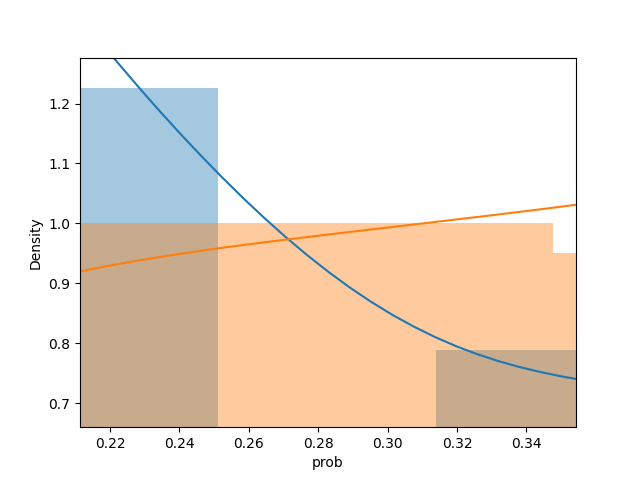

C:\Users\SHUBHAM SHARMA\AppData\Local\Temp\ipykernel_16932\2526052375.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( train_pf.loc[ train_pf.actual ==  1, 'prob'])


<AxesSubplot: xlabel='prob', ylabel='Density'>

In [95]:
sns.distplot( train_pf.loc[train_pf.actual == 0, 'prob'] )
sns.distplot( train_pf.loc[ train_pf.actual ==  1, 'prob'])